In [62]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from omegaconf import OmegaConf
import numpy as np

from model import Model
from dataset import *

import umap
import matplotlib as mpl

from torchtnt.utils.device import copy_data_to_device

root = "./experiments/cifar100_resnet18_linear_100d"
device = "cuda:1"

with open(f"{root}/.hydra/config.yaml", "r") as f:
    cfg = OmegaConf.load(f)

# Load

In [63]:
module = Model(
    dim_in=cfg.model.dim_in,
    dim_out=cfg.model.dim_out,
    backbone=cfg.model.backbone,
    activation=torch.nn.functional.leaky_relu,
    alpha=cfg.train.loss_coefs.alpha,
    beta=cfg.train.loss_coefs.beta,
    kernel=cfg.model.kernel,
    device=device,
).to(device)

trainloader = get_loader(
    dataset=cfg.val.dataset,
    split="train",
    img_size=cfg.general.img_size,
    batch_size=cfg.train.batch_size,
    num_workers=cfg.train.num_workers,
    pin_memory=cfg.train.pin_memory,
    persistent_workers=cfg.val.persistent_workers,
)

testloader = get_loader(
    dataset=cfg.val.dataset,
    split="test",
    img_size=cfg.general.img_size,
    batch_size=cfg.train.batch_size,
    num_workers=cfg.train.num_workers,
    pin_memory=cfg.train.pin_memory,
    persistent_workers=cfg.val.persistent_workers,
)

CIFAR100
Files already downloaded and verified
CIFAR100
Files already downloaded and verified


# Embed

In [64]:
state_dict = torch.load(os.path.join(root, "state_dict.pt"), map_location="cpu", weights_only=True)
module.load_state_dict(state_dict)
module.eval()

for i, data in enumerate(trainloader):
    data = copy_data_to_device(data, device=device)
    with torch.no_grad():
        x, _ = module.embed(data)
        module.remember(x, data)

module.update_minterms()
basis = torch.cat(module._minterm_evecs, dim=0)

module.forget()

for i, data in enumerate(testloader):
    data = copy_data_to_device(data, device=device)
    with torch.no_grad():
        x, _ = module.embed(data)
        module.remember(x, data)

module.update_minterms()

In [65]:
embeddings = F.normalize(torch.cat(module._minterm_samples, dim=0), dim=-1, p=2)

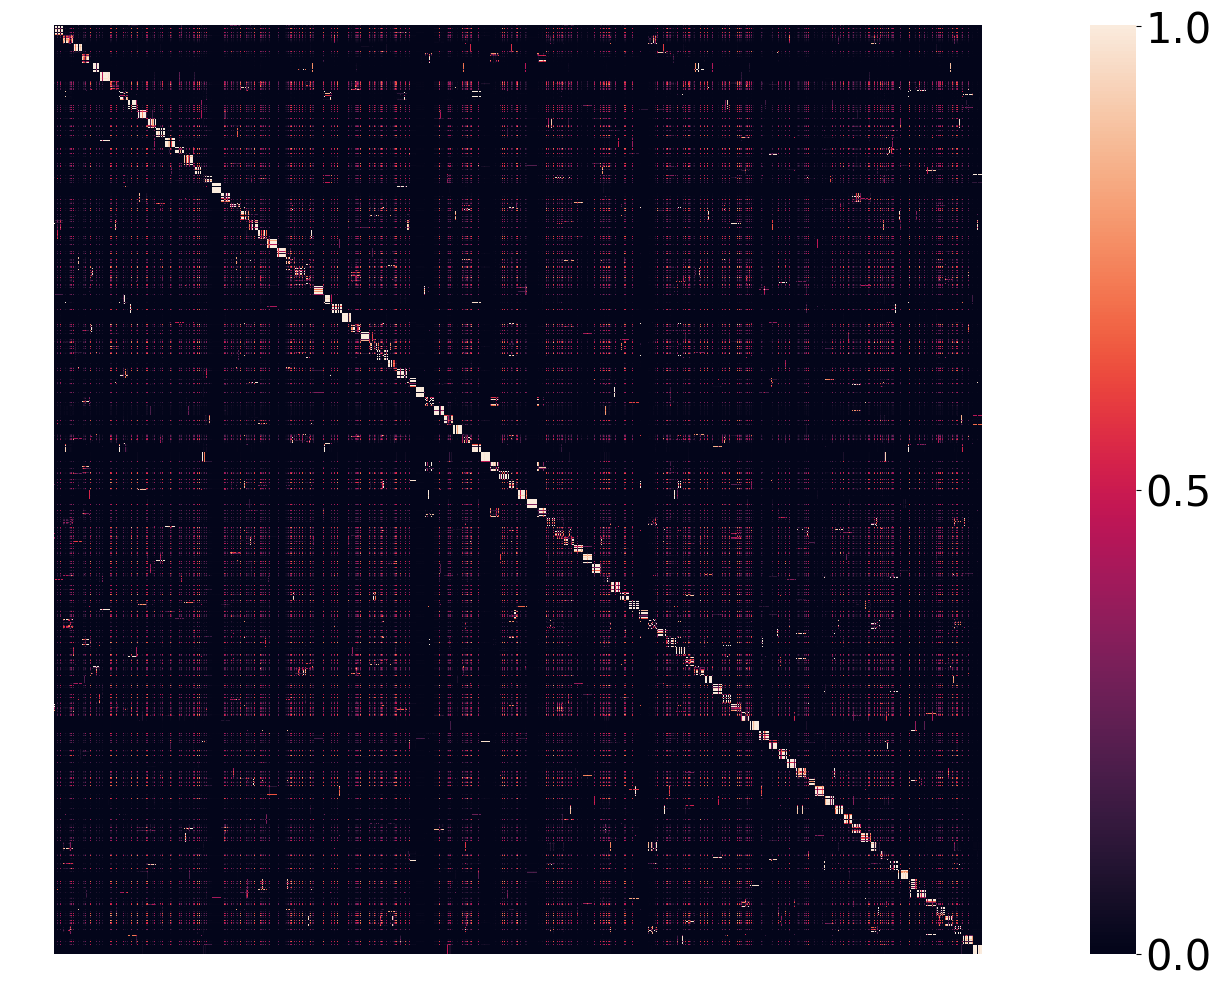

In [67]:
import seaborn as sns
fig = plt.figure(figsize=(13,10))
#ax = sns.heatmap((basis @ basis.T).cpu() ** 2)
ax = sns.heatmap((embeddings @ embeddings.T).cpu() ** 2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
cbar.set_ticks([0, 0.5, 1.0])
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
fig.savefig(f"./{cfg.general.name}_test_embed.png", bbox_inches="tight")

# UMAP

In [ ]:
reducer = umap.UMAP(n_neighbors=80, min_dist=0.05)
umap_embeddings = reducer.fit_transform(embeddings.numpy()[::1,:])

In [ ]:
umap_embeddings = embeddings

# Visualize

In [ ]:
import matplotlib.patches as mpatches
cmap = mpl.colormaps['Set1']

class_select = list(loader.dataset.class_to_idx.keys()) #["Bald", "Male", "Eyeglasses"]

i = [loader.dataset.class_to_idx[c] for c in class_select]

unique, idx = torch.unique(labels[:,i], dim=0, return_inverse=True)
color = cmap(idx / idx.max())
color[:,-1] = 0.5

patches = []
for i, sgn in enumerate(unique):
    patches.append(mpatches.Patch(color=cmap(i / (len(unique)-1)), label=" AND ".join(["NOT "*(sgn[i] == 0) + class_select[i] for i in range(len(class_select))])))

plt.figure(figsize=(20,10))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], 12.0, c=color[::1])
#plt.legend(handles=patches, fontsize=7)
plt.axis("equal")
plt.axis("off")
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#ax = plt.gca()
#for i in range(0,len(X_embedded),100):
#    ab = AnnotationBbox(OffsetImage(images[i].permute(1,2,0).cpu(), zoom=1.0), (X_embedded[i,0], X_embedded[i,1]), frameon=False)
#    ax.add_artist(ab)